In [27]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K


In [28]:
INIT_LR = 1e-3
BATCH_SIZE =25
EPOCHS = 5
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "diseases"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [29]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    batch_size=24,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
)

Found 291 files belonging to 24 classes.


In [30]:
class_names = dataset.class_names
class_names

['ArmyWorm',
 'BPH',
 'BackterialLeaf',
 'CaseWorm',
 'FalseSmut',
 'GoldenAppleSnail',
 'GrainDiscoloration',
 'GreenLeafHopper',
 'LeafScald',
 'RiceBlast',
 'RiceBug',
 'RiceEarBug',
 'RiceGallMidge',
 'RiceLeafFolder',
 'RiceMealyBug',
 'RiceRootAphid',
 'RiceStemBorer',
 'RiceThrips',
 'RiceWhorlMaggot',
 'SheathBlight',
 'SheathRot',
 'WhitePlanthopper',
 'ZigzagLeafhopper',
 'healty']

In [31]:
len(dataset)

13

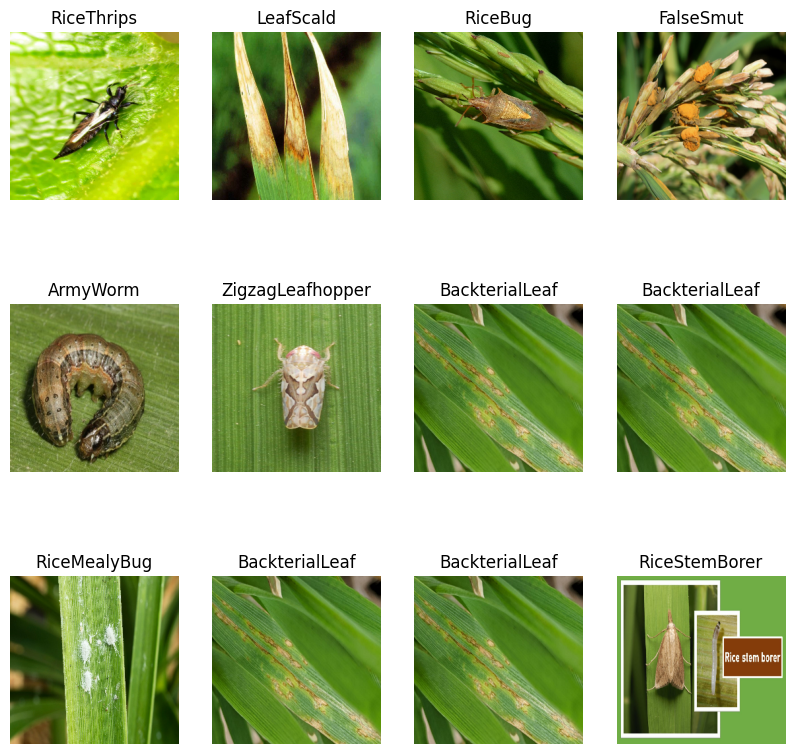

In [32]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [33]:
len(dataset)

13

In [34]:
print("80% -> Training")
print("20% -> 10% Validation, 10% Test")

80% -> Training
20% -> 10% Validation, 10% Test


In [35]:
train_size = 0.8
len(dataset)*train_size

10.4

In [36]:
train_ds = dataset.take(8)
len(train_ds)

8

In [37]:
test_ds = dataset.skip(8)
len(test_ds)

5

In [38]:
val_size = 0.1
len(dataset)*val_size

1.3

In [39]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [40]:
test_ds = test_ds.skip(1)
len(test_ds)

4

In [41]:
def get_dataset_partitions_tf(ds, train_split =0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 228):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [42]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [43]:
len(train_ds)

10

In [44]:
len(val_ds)

1

In [45]:
len(test_ds)

2

In [46]:
train_ds = train_ds.cache().shuffle(228).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(228).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(2).prefetch(buffer_size = tf.data.AUTOTUNE)

In [47]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [48]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [49]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = input_shape)

In [50]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (25, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (25, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (25, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (25, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (25, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (25, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (25, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (25, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (25, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (25, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (25, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (25, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (25, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (25, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (25, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (25, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (25, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [52]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\grian\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\grian\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1986, in _run_once

  File "C:\Users\grian\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3047, in run_cell

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3102, in _run_cell

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3489, in run_ast_nodes

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3549, in run_code

  File "C:\Users\grian\AppData\Local\Temp\ipykernel_8712\1164260581.py", line 1, in <module>

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 371, in fit

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 219, in function

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 132, in multi_step_on_iterator

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 113, in one_step_on_data

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 60, in train_step

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\keras\src\trainers\trainer.py", line 383, in _compute_loss

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\keras\src\trainers\trainer.py", line 351, in compute_loss

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\keras\src\trainers\compile_utils.py", line 690, in __call__

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\keras\src\trainers\compile_utils.py", line 699, in call

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\keras\src\losses\loss.py", line 67, in __call__

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\keras\src\losses\losses.py", line 33, in call

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\keras\src\losses\losses.py", line 2246, in sparse_categorical_crossentropy

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\keras\src\ops\nn.py", line 1964, in sparse_categorical_crossentropy

  File "C:\Users\grian\desktop\rice_sentry_server\venv\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 744, in sparse_categorical_crossentropy

Received a label value of 23 which is outside the valid range of [0, 3).  Label values: 0 17 19 2 6 0 9 9 2 16 2 9 14 9 10 4 16 1 11 15 10 17 20 23
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_multi_step_on_iterator_7028]

In [ ]:
scores = model.evaluate(test_ds)